In [1]:
%matplotlib inline
import fits
import calcPhysicalDist as pd
import findTrend as ft
import math
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import random, time, os, copy
import pickle
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit

In [2]:
"""
*****************************************************************************
                                   Parameters
*****************************************************************************
"""
#Settings
#============================================================================
showProgressBars = True                                       # Show the progress of tasks
generateCompletenessPlots = False                             # Plot completeness plot as a function of r-band mag
generateDnHist1D = False                                      #
generateDnHist2D = False                                      #
generateKDEPlots = False                                      #
generateDnWithCorrectionHist2D = False                        #
generateMaguntudeLimitPlot = False                            #

# Dn4000 Constraints 
#============================================================================
Dn4000Max = 3.0                                               #
Dn4000Min = 0.0                                               #

# Cluster List
#============================================================================
fullClusterList = fits.clusters                               # List of all clusters in the dataset
clustersToIgnore = []                                         # List of cluster to exclude for the analysis

# File Directories
#============================================================================
spectroscopicMemberDataFileDir = "./HeCS_omnibus_dn4000.fits" # File path for spectrospoic members dataset
clusterObjectData3r200FileDir = "./HeCS_omnibus_3r200.fits"   # File path for all object within 3R200 of the cluster center
clusterDataFileDir = "./HeCS_omnibus_cluster_center.txt"      # File path for infomation about the overall cluster i.e R200, M200 and redshift
completenessPlotsDir = "./CompletenessPlots"                  # File path where the completeness plot will be saved
DnHist1DDir = "./DnHist1D"                                    #
DnHist2DDir = "./DnHist2D"                                    #
KDEPlotsDir = "./KDEPlots"                                    #
DnWithCorrectionHist2DDir = "./DnWithCorrectionHist2D"        #
maguntudeLimitPlotDir = "./MaguntudeLimit"                    #

# Completeness/Membership fraction calculations
#============================================================================
rbandBinSize = 1.0                                            # Rband apparent magnitude Bin Size in Mpc
completenessLimit = 0.5                                       # Completeness limit to calculate/use in the program (between 0.0-1.0) i.e. 0.5 = 50% completeness limit
rbandMax = 100                                                # Max r-band value for calculating the completeness limt
rbandMin = 15                                                 # Min r-band value for calculating the completeness limt

# Membership correction parameter 
#============================================================================

# General
#----------------------------------------------------------------------------
imposeLimitOnCorrection = True                                #

# Bin Sizes
#----------------------------------------------------------------------------
rnormBinSize = 0.25                                           # Rnorm (Rcl / R200) Bin Size
MrBinSize = 0.8                                               # Abs. R-Band Magnitude Bin Size
grBinSize = 0.25                                              # g-r Color Bin Size

# Bin Constraints (Value of None the max/min values in dataset will be taken)
#----------------------------------------------------------------------------
rnormMax = None                                               # Max Rnorm (Rcl / R200) Value
rnormMin = None                                               # Min Rnorm (Rcl / R200) Value
MrMax = -20  #-18.02                                          # Max Abs. R-Band Magnitude Value
MrMin = -24.0#-21.22                                          # Min Abs. R-Band Magnitude Value
grMax = 1.4                                                   # Max g-r Color Value
grMin = 0.4                                                   # Min g-r Color Value

# KDE Parameters
#----------------------------------------------------------------------------
dn4000Binwidth = 0.1                                          # 
rNormBinwidth = 0.15                                          # 
showOptimalBandwidth = False                                  # 

# Maguntude Limit Calculation parameter 
#============================================================================
redshiftBinMin = None
redshiftBinMax = None #0.31
redshiftBinNum = 10

massBinMin = None
massBinMax = None #1842480000000000.0
massBinNum = 4

In [3]:
"""
*****************************************************************************
                         Fetches The Relevant Data
*****************************************************************************
"""
# Spectroscopic members
dataSpec = fits.fetchFITS(spectroscopicMemberDataFileDir, 's')
# All members within 3*R200 
_data = fits.fetchFITS(clusterObjectData3r200FileDir, 's')

# Generates a dictionary from the data from the fit files 
clusterDict = fits.getClusterDict(_data)
clusterDictSpec = fits.getClusterDict(dataSpec)

# Cluster data
centerData = np.loadtxt(clusterDataFileDir, dtype='str')

In [4]:
"""
*****************************************************************************
                                Cleans Data
*****************************************************************************
"""
clusterList = []
for cluster in fullClusterList:
    if(cluster not in clustersToIgnore):
        clusterList.append(cluster)

In [13]:
"""
*****************************************************************************
                              Function Definitions
*****************************************************************************
"""
# Returns an array of common values in N arrays
# Parameters are a series of arrays
def IntersecOfSets(*args):
    # Converts the arrays to sets
    sets = np.array([set(i) for i in args])
    
    # Check for intersection between the sets
    resultSet = sets[0]
    for s in sets[1:]:
        resultSet = resultSet.intersection(s)

    # Converts intersection set to an array
    finalList = list(resultSet)
    
    return finalList

# Generate a dictionary that stores the luminosity distance for each cluster
def getLumDistDict():
    # Initializing the dictionary
    lumDistDict = {cluster: None for cluster in clusterList}
    
    # Setting up the cosmological model
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

    # Calculates the luminosity distance for each cluster
    for cluster, redshift in zip(centerData[:,0], centerData[:,3]):
        redshift = float(redshift)       
        lumDistance = cosmo.luminosity_distance(redshift) 
        lumDistDict[cluster] = lumDistance.value
    return lumDistDict

# Calculates the Absolute Magnitude 
def getAbsMag(m, cluster, lumDistDict):
    return m - 5.000000 * math.log10(lumDistDict[cluster] * 1.000000e6) + 5.000000

# Generate a sub dictionary that consist of just cluster members
def genMemberDict(lumDistDict):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Generating Member Dictionary"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    # Initializing the dictionary
    memberClusterDict = {cluster: [] for cluster in clusterList}

    # Find all cluster member object in each cluster
    for cluster in pbar(clusterList):
        # Creates an empty array to store the cluster data
        c = np.empty(len(clusterDict[cluster]), dtype=object)
        
        # Stores the cluster object data
        for i, (data) in enumerate(clusterDict[cluster]):
            c[i] = data

        # Loops through each object in the cluster     
        for objectData in c:
            # Checks if the object is a cluster member or not
            if(objectData[6] == 'Y'):
                temp = []
                temp.extend(objectData)
                # Loop through each of the spectroscopic members
                for data in clusterDictSpec[cluster]:
                    # Check if the current member and the current spectroscopic
                    # member are the same. If they are additional data is added.
                    if (data[2].strip() == objectData[1].strip()):
                        temp.extend([data[1], data[5], data[8], getAbsMag(objectData[11], cluster, lumDistDict)])
                        break
                memberClusterDict[cluster].append(temp)
        
    return memberClusterDict

# Calculates the completness and memberfraction for each cluster and
# stores the result in two dictionaries one with completness and the other with the
# memberfraction. Both dictionaries also stores the Rnorn bin the fraction was calculated.
def CalcCompletness():
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Calculating Completeness and Member Fraction for Each Cluster"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    
    # Initializing the completeness and memberfraction dictionaries
    memberfractionDict, completnessDict = {}, {}

    for cluster in pbar(clusterList):
        # Check if the cluster contains any objects
        if (cluster not in clusterDict):
            continue
        elif(len(clusterDict[cluster]) == 0):
            completnessDict[cluster] = None
            memberfractionDict[cluster] = None
            continue
        
        # Initializing the clusters fraction and rnrom bins to empty arrays
        memberfractionDict[cluster] = [[], []]
        completnessDict[cluster] = [[], []]

        # Sets up arrays to store the redshift, rband mag and member status
        redshift = np.empty(len(clusterDict[cluster]), dtype=float)
        rband = np.empty(len(clusterDict[cluster]), dtype=float)
        isMember = np.empty(len(clusterDict[cluster]), dtype=str)  
        
        # Gets the redshift, rband mag and member status from clusterDict
        for i, (data) in enumerate(clusterDict[cluster]):
            redshift[i] = data[4]
            rband[i] = data[11]
            isMember[i] = data[6]

        # Gets the number of rband bins
        binSize = rbandBinSize 
        RbandMax = np.max(rband)
        RbandMin = np.min(rband)
        binNum = int(math.ceil((RbandMax - RbandMin)/ binSize))

        # Gets the indices for the values in each bin of rband apparent mag
        indexBins = [np.where(np.logical_and(rband > i * binSize + RbandMin,  rband < (i+1) * binSize + RbandMin))  for i in range(binNum)]

        for indices in indexBins:
            # Finds the number of members, spectroscopic members and total objects
            numSpec, numTotal, numMem = 0, 0, 0
            for z, m in zip(redshift[indices], isMember[indices]):
                if (z > -1):
                    numSpec += 1
                if(m == 'Y'):
                    numMem += 1 
                numTotal += 1
            
            # Calculates the completeness in the current rband bin
            if(numTotal != 0):
                completnessDict[cluster][0].append(numSpec / numTotal)
                completnessDict[cluster][1].append(np.mean(rband[indices]))
            # Calculates the member fraction in the current rband bin
            if(numSpec != 0):
                memberfractionDict[cluster][0].append(numMem / numSpec)
                memberfractionDict[cluster][1].append(np.mean(rband[indices]))
        
    return completnessDict, memberfractionDict

# Calculates the completeness limit
def getCompletenessLimit(completnessDict):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Calculating the Completeness Limit for Each Cluster"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    # Initializing the completeness limit dictionaries
    compLimit = {}
    
    for cluster in pbar(clusterList):
        # Checks if the completnessDict is not None
        if(cluster not in completnessDict):
            continue
        elif(completnessDict[cluster] is None):
            compLimit[cluster] = None
            continue
      
        # Gets the completeness and the r-band mag values
        rband = np.array(completnessDict[cluster][1])
        completeness = np.array(completnessDict[cluster][0])

        # Gets the indices of the arrays for r-band mag values within the min/max value range
        index = np.where(np.logical_and(rband > rbandMin, rband < rbandMax)) 
        
        if (generateCompletenessPlots):
            # Initializes a spline and computes y values for ploting
            f = InterpolatedUnivariateSpline(rband[index], completeness[index])
            xdata = np.linspace(np.min(rband[index]), np.max(rband[index]), 1000)
            ydata = f(xdata)
            
            # Plots the completeness as a function of member fraction
            plt.plot(xdata, ydata)
            plt.xlabel("r-band mag")
            plt.ylabel("completeness")
            plt.xlim(rbandMin, rbandMax)
            plt.title(cluster) 
    
        try:
            # Initializes a spline for when the y values are shift down by the completeness limit
            invf = InterpolatedUnivariateSpline(rband[index], completeness[index] - completenessLimit)
            # Finds the right most root and stores the limit in the limit50 dictionary 
            limit = invf.roots()[-1]
            compLimit[cluster] = limit
            
            if (generateCompletenessPlots):
                # Plots the completeness limit
                plt.axvline(x=limit, label=f"{completenessLimit * 100.0}% completeness limit")
                plt.legend(loc="best")
        except:
            # Case where the complenetess never reaches the completeness limit
            compLimit[cluster] = None
            pass
        
        if (generateCompletenessPlots): 
            plt.savefig(completenessPlotsDir + "/" + cluster + ".png")
    
    return compLimit


# Calculates the number of additional members required
def calcAdditonalMemeber(Nphot, fcomp, fmem):
    return Nphot * (1 - fcomp) * fmem

#Finds the number of additional members requried for each cluster
def getAdditionalMemberDict(memberClusterDict, lumDistDict, compLimit):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Calculating the Number of Additional Members for Each Cluster"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    # Initializes two dictionaries to store the number of additional members
    # with and without the completeness limit imposed.
    additionalMembersDict, additionalMembersLimitDict = {}, {}
    for cluster in pbar(clusterList): 
        # Check if cluster is in member dict and if the number of object is greater than zero
        if(cluster not in memberClusterDict):
            continue
        if (len(memberClusterDict[cluster]) == 0):
            additionalMembersDict[cluster], additionalMembersLimitDict[cluster] = None, None
            continue
        
        # Initializes variables
        additionalMembersDict[cluster], additionalMembersLimitDict[cluster] = [], []
        redshift, rband, Mr, gr, rnorm, dn4000, Nphot, isMember = [], [], [], [], [], [], [], []

        # Gets the redshift, rband mag, Mr, g-r, Dn4000 and member status of each object
        for d in clusterDict[cluster]:
            redshift.append(d[4])
            rband.append(d[11])
            Mr.append(getAbsMag(d[11],cluster, lumDistDict))
            gr.append(d[9] - d[11])
            dn4000.append(d[17])
            isMember.append(d[6])

        # Converts arrays to numpy arrays
        redshift = np.array(redshift)
        rband = np.array(rband)
        Mr = np.array(Mr)
        gr = np.array(gr)
        dn4000 = np.array(dn4000)   

        # Gets Indices for each Mr bin
        _MrMax = MrMax if(MrMax is not None) else np.max(Mr)
        _MrMin = MrMin if(MrMin is not None) else np.max(Mr)
        MrBinNum = int(math.ceil(abs(_MrMax - _MrMin)/ MrBinSize))
        MrIndexBins = [np.where(np.logical_and(Mr >= np.min(Mr), Mr <= _MrMin))]
        MrIndexBins.extend([np.where(np.logical_and(Mr > i * MrBinSize + _MrMin,  Mr <= (i+1) * MrBinSize + _MrMin))  for i in range(MrBinNum)])
        MrIndexBins.extend([np.where(np.logical_and(Mr > _MrMax, Mr <= np.max(Mr)))])

        # Get Indices for each g-r bin
        _grMax = grMax if(grMax is not None) else np.max(gr)
        _grMin = grMin if(grMin is not None) else np.max(gr)
        grBinNum = int(math.ceil(abs(grMax - grMin)/ grBinSize))
        grIndexBins = [np.where(np.logical_and(gr > -0.5, gr <= _grMin))]
        grIndexBins.extend([np.where(np.logical_and(gr > i * grBinSize + _grMin,  gr <= (i+1) * grBinSize + _grMin))  for i in range(grBinNum)])
        grIndexBins.extend([np.where(np.logical_and(gr > _grMax, gr <= 2.5))])
        
        # Loops through each g-r bin
        for grIndices in grIndexBins:
            # Temp array to store the additional members for the current g-r bin
            temp, tempLimit = [], []
            
            # Loops through each Mr bin
            for MrIndices in MrIndexBins:
                # Inits the number of spectropic members, members and objects 
                numSpec, numMem, numTotal = 0, 0, 0
                # Inits the number of spectropic members, members and objects within the completeness limit
                numSpecL, numMemL, numTotalL = 0, 0, 0
                # Gets the common indcies between the g-r and Mr bins
                indices = IntersecOfSets(grIndices[0], MrIndices[0])
                for index in indices:
                    # Gets the number of spectropic members, members and objects within the completeness limit
                    if (cluster in compLimit and compLimit[cluster] is not None):
                        if(rband[index] <= compLimit[cluster]):
                            if (redshift[index] > -1):
                                numSpecL += 1
                            if(isMember[index] == 'Y'):
                                numMemL += 1 
                            numTotalL += 1
                    # Gets the number of spectropic members, members and objects
                    if (redshift[index] > -1):
                        numSpec += 1
                    if(isMember[index] == 'Y'):
                        numMem += 1 
                    numTotal += 1
                
                # Calculates the number of additional members 
                if (numTotal != 0 and numSpec != 0):
                    fcomp = numSpec /numTotal
                    fmem = numMem / numSpec
                    temp.append(calcAdditonalMemeber(numTotal, fcomp, fmem))
                else:
                    temp.append(None)
                    
                # Calculates the number of additional members within the completeness limit
                if (numTotalL != 0 and numSpecL != 0):
                    fcompL= numSpecL /numTotalL
                    fmemL= numMemL / numSpecL
                    tempLimit.append(calcAdditonalMemeber(numTotalL, fcompL, fmemL))
                else:
                    tempLimit.append(None)
                        
            additionalMembersDict[cluster].append(temp)
            additionalMembersLimitDict[cluster].append(tempLimit)

    return additionalMembersDict, additionalMembersLimitDict

# Gets the redshift, r-band apparent/absolute mag, g-r color, Rnorm and Dn4000 for a cluster
def getParametersFromDataset(memberClusterDict, cluster):  
    # Fetching list of each parameter
    c = np.array(memberClusterDict[cluster])
    
    # Gets required paraemeters
    redshift = c[:,4].astype(float)
    rband = c[:,11].astype(float)
    Mr = c[:,22].astype(float)
    gr = c[:,9].astype(float) - c[:,11].astype(float)
    rnorm = c[:,20].astype(float) / c[:,19].astype(float)
    dn4000 = c[:,17].astype(float)
    
    # Conert to numpy arrays
    redshift = np.array(redshift)
    rband = np.array(rband )
    Mr = np.array(Mr)
    gr = np.array(gr)
    rnorm = np.array(rnorm)
    dn4000 = np.array(dn4000) 
    
    return redshift, rband, Mr, gr, rnorm, dn4000 

# Gets the stacked redshift, r-band apparent/absolute mag, g-r color, Rnorm and Dn4000
def getParametersFromStackedDataset(memberClusterDict):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Getting Stacked Sampled Parameters"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    
    # Initializing parameter arrays
    redshift, rband, Mr, gr, rnorm, dn4000 = [], [], [], [], [], []
    
    for cluster in pbar(clusterList):
        if(cluster not in memberClusterDict):
            continue
        elif(len(memberClusterDict[cluster]) == 0):
            continue
    
        # Gets cluster parameters
        cluRedshift, cluRband, cluMr, cluGr, cluRnorm, cluDn4000 = getParametersFromDataset(memberClusterDict, cluster)

        # Adds to stacked samples
        redshift.extend(cluRedshift)
        rband.extend(cluRband)
        Mr.extend(cluMr)
        gr.extend(cluGr)
        rnorm.extend(cluRnorm)
        dn4000.extend(cluDn4000)
    
    # Conert to numpy arrays
    redshift = np.array(redshift)
    rband = np.array(rband )
    Mr = np.array(Mr)
    gr = np.array(gr)
    rnorm = np.array(rnorm)
    dn4000 = np.array(dn4000)   
    
    return redshift, rband, Mr, gr, rnorm, dn4000 

# Gets the indices bins of Rnorm, Mr and g-r color used to generate the KDE/KDE related plots
def getKDEBins(rnorm, Mr, gr):
    # Rnorm indice bins
    _rnormMax = rnormMax if(rnormMax is not None) else np.max(rnorm)
    _rnormMin = rnormMin if(rnormMin is not None) else np.min(rnorm)
    rnormBinNum = int(math.ceil(abs(_rnormMax - _rnormMin)/ rnormBinSize))
    rnormIndexBins = [np.where(np.logical_and(rnorm > i * rnormBinSize + _rnormMin,  rnorm <= (i+1) * rnormBinSize + _rnormMin))  for i in range(rnormBinNum)]
    
    # Mr indice bins
    _MrMax = MrMax if(MrMax is not None) else np.max(Mr)
    _MrMin = MrMin if(MrMin is not None) else np.min(Mr)
    MrBinNum = int(math.ceil(abs(_MrMax - _MrMin)/ MrBinSize))
    MrIndexBins = [np.where(np.logical_and(Mr >= np.min(Mr), Mr <= _MrMin))]
    MrIndexBins.extend([np.where(np.logical_and(Mr > i * MrBinSize + _MrMin,  Mr <= (i+1) * MrBinSize + _MrMin))  for i in range(MrBinNum)])
    MrIndexBins.extend([np.where(np.logical_and(Mr > _MrMax, Mr <= np.max(Mr)))])
    
    # g-r color indice bins
    _grMax = grMax if(grMax is not None) else np.max(gr)
    _grMin = grMin if(grMin is not None) else np.min(gr)
    grBinNum = int(math.ceil(abs(_grMax - _grMin)/ grBinSize))
    grIndexBins = [np.where(np.logical_and(gr > -0.5, gr <= _grMin))]
    grIndexBins.extend([np.where(np.logical_and(gr > i * grBinSize + _grMin,  gr <= (i+1) * grBinSize + _grMin))  for i in range(grBinNum)])
    grIndexBins.extend([np.where(np.logical_and(gr > _grMax, gr <= 2.5))])
    
    return rnormIndexBins, MrIndexBins, grIndexBins

# Generate 2D KDE for a given set of data
def getKDEs(data):
    params = {"bandwidth": np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(), params)
    grid.fit(data)

    if(showOptimalBandwidth): 
        print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
    
    kde = grid.best_estimator_
    
    return kde

# Samples the additional members for eac bin of Mr, g-r color
def sampleAdditionalMembers(memberClusterDict, additionalMembersDict):
    # Getting parameter arrays
    redshift, rband, Mr, gr, rnorm, dn4000 = getParametersFromStackedDataset(memberClusterDict) 
    
    # Applies Dn4000 limits
    redshift = redshift[np.where(np.logical_and(dn4000 > Dn4000Min, dn4000 < Dn4000Max))]
    rband = rband[np.where(np.logical_and(dn4000 > Dn4000Min, dn4000 < Dn4000Max))]
    Mr = Mr[np.where(np.logical_and(dn4000 > Dn4000Min, dn4000 < Dn4000Max))]
    gr = gr[np.where(np.logical_and(dn4000 > Dn4000Min, dn4000 < Dn4000Max))]
    rnorm = rnorm[np.where(np.logical_and(dn4000 > Dn4000Min, dn4000 < Dn4000Max))]
    dn4000 = dn4000[np.where(np.logical_and(dn4000 > Dn4000Min, dn4000 < Dn4000Max))]
    
    # Gets the indice bins for Rnorm, Mr, and g-r color
    rnormIndexBins, MrIndexBins, grIndexBins = getKDEBins(rnorm, Mr, gr) 
    
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Sampling The Additional Members for Each Cluster"]   
    pbar = progressbar.ProgressBar(max_value=len(MrIndexBins), widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    
    # Initalizes an array that will contain all the sampled data points
    sampledData = []
    
    # Initalizes plots
    fig, axs = [None, None, None, None], [None, None, None, None]
    i, j = [0, 0, 0, 0], [0, 0, 0, 0]
    colorbars = np.array([[None for i in range(len(grIndexBins))] for j in range(len(MrIndexBins))])              
    
    for MrBinNum, (MrIndices) in enumerate(MrIndexBins):
        for grBinNum, (grIndices) in enumerate(grIndexBins):
            
            additionalMembers = 0
            for cluster in clusterList:
                if cluster in additionalMembersDict:
                    if(additionalMembersDict[cluster] is None or (additionalMembersDict[cluster] == np.array(None)).all()):
                        continue             
                    elif (len(additionalMembersDict[cluster]) <= 0):
                        continue
                    elif (additionalMembersDict[cluster][grBinNum][MrBinNum] is not None and additionalMembersDict[cluster][grBinNum][MrBinNum] != 0):
                        additionalMembers += additionalMembersDict[cluster][grBinNum][MrBinNum] 
            if(len(IntersecOfSets(MrIndices[0], grIndices[0])) < 5):
                sampledData.append([None] * len(IntersecOfSets(MrIndices[0], grIndices[0])))
                continue
            
            data = np.vstack([rnorm[IntersecOfSets(MrIndices[0], grIndices[0])], dn4000[IntersecOfSets(MrIndices[0], grIndices[0])]]).T    
            kde = getKDEs(data)
            new_data = kde.sample(int(additionalMembers), random_state=0)
            sampledData.append(new_data)
        # Updates Progress Bar
        pbar.update(MrBinNum + 1)
        
    return sampledData

# Assignes Additional Member to each cluster and returns a dictionary
# that consist of the original data and the data with the correction
# applied.
def assignAdditionalMembers(memberClusterDict, additionalMembersDict, sampledData):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Assigning The Additional Members to Each Cluster"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    
    # Inits a dictionary to caontain the uncorrected and corrected data for
    # each cluster
    plotDataDict = {cluster: [] for cluster in fits.clusters}
    
    for cluster in pbar(clusterList):
        if(cluster not in memberClusterDict):
            continue
        elif (len(memberClusterDict[cluster]) == 0):
            continue
            
        additionalMembers = []
        if cluster in additionalMembersDict:   
            for rnum, row in enumerate(additionalMembersDict[cluster]):
                for i, (numberofAdditionalMember) in enumerate(row):
                    if (numberofAdditionalMember == None): 
                        continue
                    elif (len(sampledData[i * len(additionalMembersDict[cluster]) + rnum]) == 0):
                        continue
                    elif ((np.array(sampledData[i * len(additionalMembersDict[cluster]) + rnum]) == None).all()):
                        continue
                    for memberIndex in range(int(numberofAdditionalMember)):
                        element = sampledData[i * len(additionalMembersDict[cluster]) + rnum][memberIndex]
                        element = np.append(element, [1])
                        if (len(element) < 3): continue
                        additionalMembers.append([element[1], element[0], element[2], None, None])
        
        # Gets the clusters redshift, Mr, Rnorm and Dn4000
        redshift, _ , Mr, _, rnorm, dn4000 = getParametersFromDataset(memberClusterDict, cluster)
        
        # Adds the data without correction to the dataset
        rawData = np.vstack([dn4000, rnorm, [0] * len(rnorm), Mr, redshift]).T
        plotDataDict[cluster].append(rawData)
        
        # Gets the data with the correction
        newData = None
        if(len(additionalMembers) != 0):
            newData = np.concatenate((rawData, additionalMembers), axis = 0)
        else:
            newData = rawData
        plotDataDict[cluster].append(newData) 
        
        # Adds the data with just the corrected objects to the dataset
        plotDataDict[cluster].append(np.array(additionalMembers))
    
    return plotDataDict

#
def getStackedSample(plotDataDict, dataIndex=1):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Preparing The Stacked Sample"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()

    _clusters = centerData[:,0]
    _redshift = centerData[:,1].astype(np.float)
    _M200 = centerData[:,3].astype(np.float)
    _R200 = centerData[:,2].astype(np.float)

    clusters, redshift, M200, R200, Mr, zo = [], [], [], [], [], []

    medDn4000, meanRnorm = [], []

    Dn400Stacked, rnornStacked, MrStacked, zoStacked = [], [], [], []
    
    for cluster in pbar(clusterList):
        if cluster not in plotDataDict:
            continue
        elif (len(plotDataDict[cluster]) == 0):
            continue
        for index, c in enumerate(_clusters):
            if(cluster == c):
                clusters.append(_clusters[index])
                redshift.append(_redshift[index])
                M200.append(_M200[index])
                R200.append(_R200[index])

        rnorm = np.array(plotDataDict[cluster][dataIndex][:,1])
        Dn4000 = np.array(plotDataDict[cluster][dataIndex][:,0])
        Mr = np.array(plotDataDict[cluster][dataIndex][:,3])
        zo = np.array(plotDataDict[cluster][dataIndex][:,4])

        c1 = np.where(np.logical_and(Dn4000 > 0, Dn4000 < 3))

        Dn4000 = Dn4000[c1]
        zo = zo[c1]
        rnorm = rnorm[c1]
        Mr = Mr[c1]

        c4 = np.where(rnorm > 0)

        Dn4000 = Dn4000[c4]
        rnorm = rnorm[c4]
        Mr = Mr[c4]
        zo = zo[c4]

        binSize = 200 * 0.001 # Mpc
        RclMax = np.max(rnorm)
        binNum = int(math.ceil(RclMax/ binSize))

        indexBins = [np.where(np.logical_and(rnorm > i * binSize,  rnorm < (i+1) * binSize))  for i in range(binNum)]

        Dn400Stacked.append(Dn4000)
        rnornStacked.append(rnorm)
        MrStacked.append(Mr)
        zoStacked.append(zo)

        medDn4000_ = []
        meanRnorm_ = []
        for i in range(len(indexBins)):
                if (Dn4000[indexBins[i]].size != 0):
                    medDn4000_.append(np.median(Dn4000[indexBins[i]]))

                if (Dn4000[indexBins[i]].size != 0):
                    meanRnorm_.append(np.mean(rnorm[indexBins[i]]))

        medDn4000.append(medDn4000_)
        meanRnorm.append(meanRnorm_)

    Dn4000Stacked = np.array(Dn400Stacked, dtype=object)
    rnornStacked = np.array(rnornStacked, dtype=object)
    MrStacked = np.array(MrStacked, dtype=object)
    zoStacked = np.array(zoStacked, dtype=object)

    medDn4000 = np.array(medDn4000, dtype=object)
    meanRnorm = np.array(meanRnorm, dtype=object)
    clusters= np.array(clusters)
    
    return clusters, redshift, M200, R200, Mr, zo, Dn400Stacked, rnornStacked, MrStacked, zoStacked, medDn4000, meanRnorm

#
def magnitudeLimit(plotDataDict):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Calculating The Magnitude Limit"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    
    clusters, redshift, M200, R200, Mr, zo, Dn400Stacked, rnornStacked, MrStacked, zoStacked, medDn4000, meanRnorm = getStackedSample(plotDataDict)
    
    redshiftBinStart = redshiftBinMin if (redshiftBinMin is not None) else np.min(redshift)
    redshiftBinEnd = redshiftBinMax if (redshiftBinMax is not None) else np.max(redshift)
    redshiftBinSize = abs(redshiftBinEnd - redshiftBinStart) / redshiftBinNum

    massBinStart = massBinMin if (massBinMin is not None) else np.min(M200)
    massBinEnd = massBinMax if (massBinMax is not None) else np.max(M200)
    massBinSize = abs(massBinEnd - massBinStart) / massBinNum

    MrLimt = []
    fig, axs = None, None
    colName = []
    if generateMaguntudeLimitPlot:
        fig, axs = plt.subplots(redshiftBinNum, massBinNum, figsize=(20,20))
        
    R200 = np.array(R200)
    for i in pbar(range(redshiftBinNum)):
        rowName = []
        for j in range(massBinNum):
            condition = np.where(np.logical_and(np.logical_and((redshiftBinStart + i * redshiftBinSize) <= redshift, (redshiftBinStart + (i + 1) * redshiftBinSize) > redshift), np.logical_and((massBinStart + j * massBinSize) <= M200, (massBinStart + (j+1) * massBinSize > M200))))
            Mr = []
            for MrS in MrStacked[condition]:
                MrSCleaned = list(filter(None, MrS))
                Mr.extend(MrSCleaned)
            if not Mr: continue 
            n, bins, patches = None, None, None
            if generateMaguntudeLimitPlot:  
                n, bins, patches = axs[i,j].hist(Mr, bins=np.arange(min(Mr), max(Mr) + 0.25, 0.25))
            else: 
                n, bins = np.histogram(Mr, bins=np.arange(min(Mr), max(Mr) + 0.25, 0.25))
            maxIndex = np.argmax(n)
            maxMr = bins[maxIndex]
            MrLimt.append(maxMr)
            if generateMaguntudeLimitPlot:
                axs[i,j].axvline(x=maxMr, c='r', zorder=2)
                rowName.append("{:.2e}".format((massBinStart + j * massBinSize)) + " < M200 < " + "{:.2e}".format((massBinStart + (j+1) * massBinSize)))
        if generateMaguntudeLimitPlot:
            colName.append(str(round(redshiftBinStart + i * redshiftBinSize, 2)) + " < z < " + str(round((redshiftBinStart + (i + 1) * redshiftBinSize), 2)))
    if generateMaguntudeLimitPlot:
        for ax, col in zip(axs[0], rowName):
            ax.set_title(col)

        for ax, row in zip(axs[:,0], colName):
            ax.set_ylabel(row, rotation=0, size='small', labelpad=70)

        fig.text(0.5, 0.95, 'Absolute Magnitude Distribution For Stacked Samples', ha='center')
        fig.text(0.5, 0.04, 'Abs Mag (Mr)', ha='center')

        plt.savefig(maguntudeLimitPlotDir + "/AbsMagStackedSample.png")
        plt.cla()
     
    return MrLimt

#
def linear(x, a, b):
    return a * x + b

#
def fitDn4000vsRnorm(data):
    pass

#
def generateDn4000vsRnormPlots(plotDataDict, errorMethod = "std"):
    # Sets up the progress bar
    widgets = [progressbar.Percentage(), progressbar.Bar(marker=u'\u2588', fill='.', left='|', right='|'), "Generating Dn4000 vs. Rnorm Plots"]   
    pbar = progressbar.ProgressBar(widgets=widgets) if(showProgressBars) else progressbar.bar.NullBar()
    
    clusters, redshift, M200, R200, Mr, zo, Dn4000Stacked, rnornStacked, MrStacked, zoStacked, medDn4000, meanRnorm = getStackedSample(plotDataDict)
    print(redshift)
    redshiftBinStart = redshiftBinMin if (redshiftBinMin is not None) else np.min(redshift)
    redshiftBinEnd = redshiftBinMax if (redshiftBinMax is not None) else np.max(redshift)
    redshiftBinSize = abs(redshiftBinEnd - redshiftBinStart) / redshiftBinNum

    massBinStart = massBinMin if (massBinMin is not None) else np.min(M200)
    massBinEnd = massBinMax if (massBinMax is not None) else np.max(M200)
    massBinSize = abs(massBinEnd - massBinStart) / massBinNum
    
    fig, axs = plt.subplots(redshiftBinNum, massBinNum, figsize=(20,20))
    colName = []
    R200 = np.array(R200)
    Dn4000Stacked = np.array(Dn4000Stacked)
    slope = []
    for i in pbar(range(redshiftBinNum)):
        rowName = []
        tempSlope = []
        for j in range(massBinNum):
            condition = np.where(np.logical_and(np.logical_and((redshiftBinStart + i * redshiftBinSize) <= redshift, (redshiftBinStart + (i + 1) * redshiftBinSize) > redshift), np.logical_and((massBinStart + j * massBinSize) <= M200, (massBinStart + (j+1) * massBinSize > M200))))
            
            clustersInBin = clusters[condition]
            Dn4000TotalMed, Dn4000Totalerr, RclTotalMean = [], [], []
            Dn4000, Rnorm = [], []
            for Mr, RnormS, Dn4000S in zip(MrStacked[condition], rnornStacked[condition], Dn4000Stacked[condition]):  
                MrCopy = copy.deepcopy(Mr)
                Dn4000SCopy = copy.deepcopy(Dn4000S)
                RnormSCopy = copy.deepcopy(RnormS)
                
                addedindeices = []
                for index, (_Mr, _Rn, _Dn) in enumerate(zip(Mr, RnormS, Dn4000S)):
                    if (_Mr == None or _Rn == None or _Dn == None):
                        addedindeices.append(index)
                Mr = np.delete(Mr, addedindeices)
                RnormS = np.delete(RnormS, addedindeices)
                Dn4000S = np.delete(Dn4000S, addedindeices)
                
                cond = np.where(Mr < MrMax)
                Rnorm.extend(RnormS[cond])
                Dn4000.extend(Dn4000S[cond])
                cond2 = np.where(MrCopy == None)
                Rnorm.extend(RnormSCopy[cond2])
                Dn4000.extend(Dn4000SCopy[cond2])
                # Adds original members
                axs[i,j].scatter(RnormS[cond], Dn4000S[cond], s = 1, alpha = 0.2, c='b')
                # Adds Additional members
                axs[i,j].scatter(RnormSCopy[cond2], Dn4000SCopy[cond2], s = 1, alpha = 0.2, c='b')

            if (len(Rnorm) != 0):    
                dmed,dmederr, rmean = ft.getMedDn4000(Rnorm, Dn4000, [0 for i in Dn4000], False)
                xx, yy, ye = [], [] ,[]

                for data in range(len(dmed)):
                    if(rmean[data] < 1.0):
                        xx.append(rmean[data])
                        yy.append(dmed[data])
                        ye.append(dmederr[data])

                popt, pcov = curve_fit(linear,xx, yy, sigma=ye)
                err =  np.sqrt(pcov.diagonal())

                x = np.linspace(0,1.0, 1000)
                y = popt[1] + popt[0]*x
                tempSlope.append(popt[0])
                axs[i,j].plot(x, y, c='black', label="y = ({slope:.2f} +/- {serr:.2f})x + ({intercept:.2f} +/- {ierr:.2f})".format(slope = popt[0], serr= err[0], intercept = popt[1], ierr=err[1]))
                axs[i,j].legend(loc="lower right")

                axs[i,j].scatter(rmean, dmed, s = 6, c='r')
                axs[i,j].set_ylim((1, 3))
                axs[i,j].errorbar(rmean, dmed, yerr=dmederr, alpha = 1, c='r', linestyle='none')
            else:
                tempSlope.append(None)
            
            axs[i,j].yaxis.tick_right()
            rowName.append("{:.2e}".format((massBinStart + j * massBinSize)) + " < M200 < " + "{:.2e}".format((massBinStart + (j+1) * massBinSize)))
        slope.append(tempSlope)
        colName.append(str(round(redshiftBinStart + i * redshiftBinSize, 2)) + " < z < " + str(round((redshiftBinStart + (i + 1) * redshiftBinSize), 2)))
    slope = np.array(slope)
    
    for ax, col in zip(axs[0], rowName):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], colName):
        ax.set_ylabel(row, rotation=0, size='small', labelpad=70)

    fig.text(0.5, 0.95, 'Absolute Magnitude Distribution For Stacked Samples', ha='center')
    fig.text(0.5, 0.04, 'Abs Mag (Mr)', ha='center')

    plt.savefig("StackedMinMagLimit.png")
    plt.cla()
    
    return slope, rowName, colName

#
def generateRelativeVelocityPlots(plotDataDict):
    clusters, redshift, M200, R200, Mr, zo, Dn4000Stacked, rnornStacked, MrStacked, zoStacked, medDn4000, meanRnorm = getStackedSample(plotDataDict, dataIndex=0)
    clusterZ = np.array(redshift)
    c = 299792458 # m/s, speed of light
    dVS = []
    RnS = []
    dn4000 = []
    plt.rcParams['savefig.facecolor']='white'
    
    for zo, zc, rnorm, dn, clu in zip(zoStacked, clusterZ, rnornStacked, Dn4000Stacked, clusters):
        dn4000.extend(dn)
        RnS.extend(rnorm)
        zo = np.array(zo)
        rnorm = np.array(rnorm)
        dV = c * abs((zo - zc)) / (1.0 + zc)
        dVS.extend(dV)

        rnormBinStart = 0
        rnormBinEnd = 3
        rnormBinNum = 30
        rnormBinSize = (rnormBinEnd - rnormBinStart) / rnormBinNum

        dVmed = []
        rmed = []
        for i in range(rnormBinNum):
            condition = np.where(np.logical_and((rnormBinStart + i * rnormBinSize) <= rnorm, (rnormBinStart + (i + 1) * rnormBinSize) > rnorm))
            dVmed.append(np.median(dV[condition]))
            rmed.append(np.mean(rnorm[condition]))

        #plt.scatter(rmed, dVmed, c='b', zorder=2, label="median")
        #plt.scatter(rnorm, dV, c='r', s=2, label="actual data")
        #plt.legend()
        #plt.title(clu + " relative velocity vs. Rnorm")
        #plt.xlabel("Rnorm (Mpc)")
        #plt.ylabel("dV")
        #plt.savefig("./dvVsRnorm/" + clu + ".png")
        #plt.cla()

    rnormBinStart = 0
    rnormBinEnd = 3
    rnormBinNum = 30
    rnormBinSize = (rnormBinEnd - rnormBinStart) / rnormBinNum

    RnS = np.array(RnS)
    dVS = np.array(dVS)
    dn4000 = np.array(dn4000)

    dVmed = []
    rmed = []
    x = []
    y = []
    d = []
    for i in range(rnormBinNum):

        condition = np.where(np.logical_and((rnormBinStart + i * rnormBinSize) <= RnS, (rnormBinStart + (i + 1) * rnormBinSize) > RnS))
        dVmed.append(np.median(dVS[condition]))
        rmed.append(np.mean(RnS[condition])) 
        for dv, rnorm, dn400 in zip(dVS[condition], RnS[condition], dn4000[condition]):
            if (dn400 > 0.9 and dn400 < 3.0):
                x.append(rnorm)
                y.append(dv)
                d.append(dn400)
 
    fig = plt.scatter(x, y, c=d, s=1, cmap=plt.get_cmap("cool"))  
    cbar = plt.colorbar(fig)
    cbar.set_label(label="Dn4000", size=10)
    plt.title("Stacked relative velocity vs. Rnorm")
    plt.xlabel("Rnorm (Mpc)")
    plt.ylabel("dV")
    plt.show()
    pass
    

100%|█████████████████████████████████████████████|Preparing The Stacked Sample


[181.124967, 176.175872, 202.361705, 139.934056, 195.000629, 333.667017, 220.158347, 258.846348, 247.477376, 247.168609, 244.403973, 173.671645, 167.697242, 230.758295, 165.233753, 240.573005, 164.660337, 24.339706, 234.904562, 351.107107, 30.539567, 18.295345, 14.063306, 18.749872, 153.42727, 170.408822, 127.133492, 173.093932, 138.397326, 176.846462, 155.602619, 357.695893, 10.440036, 173.065341, 329.344508, 255.905528, 243.426793, 338.877552, 118.348616, 136.92133, 208.000927, 207.227148, 247.557934, 195.9369, 180.050843, 240.362844, 32.379621, 233.327438, 236.246314, 159.781658, 168.831813, 190.302662, 204.038179, 197.822103, 163.526682, 136.823698, 230.600675, 230.255869, 205.474986, 209.80964, 179.417438, 167.964355, 207.422641, 168.48632, 167.303677, 358.5558, 182.579248, 184.461873, 227.728724, 205.540417, 230.303539, 208.289927, 356.065427, 342.582928, 258.100701, 173.195918, 201.572971, 197.330104, 334.087625, 195.726682, 194.653532, 202.707771, 187.468297, 255.675772, 225.28

C:\Users\Colby\Anaconda3\envs\data_analytics\lib\site-packages\ipykernel_launcher.py:678: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 60%|████████████████████████................|Generating Dn4000 vs. Rnorm PlotsC:\Users\Colby\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
C:\Users\Colby\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|████████████████████████████████████████|Generating Dn4000 vs. Rnorm Plots


(array([[-0.1644558867171491, -0.15065015629731957, -0.014162345334660762,
         -0.007368779729661584],
        [None, None, -0.14948100012968896, -0.08272177150716255],
        [None, None, None, None],
        [-0.28036211583211323, -0.1588410044358392, -0.0827811961980326,
         -0.1967854191766392],
        [-0.14291358992890124, -0.09709350666523667, -0.0749261209564876,
         -0.06335038899930012],
        [-0.11387896558586319, -0.1622367403868231, -0.22265832457527607,
         -0.08009960981581014],
        [-0.18826697750026494, -0.1389296978932885, -0.09420604257546854,
         1.0],
        [-0.2196293572587949, -0.12688076594767114, 0.008614869400426543,
         None],
        [None, None, None, -0.18724893375911075],
        [-0.10437223564041721, -0.05899768922415527, -0.0445671987043426,
         -0.10524565851523636]], dtype=object),
 ['2.04e-02 < M200 < 9.05e-02',
  '9.05e-02 < M200 < 1.61e-01',
  '1.61e-01 < M200 < 2.31e-01',
  '2.31e-01 < M200 < 3.01e-01

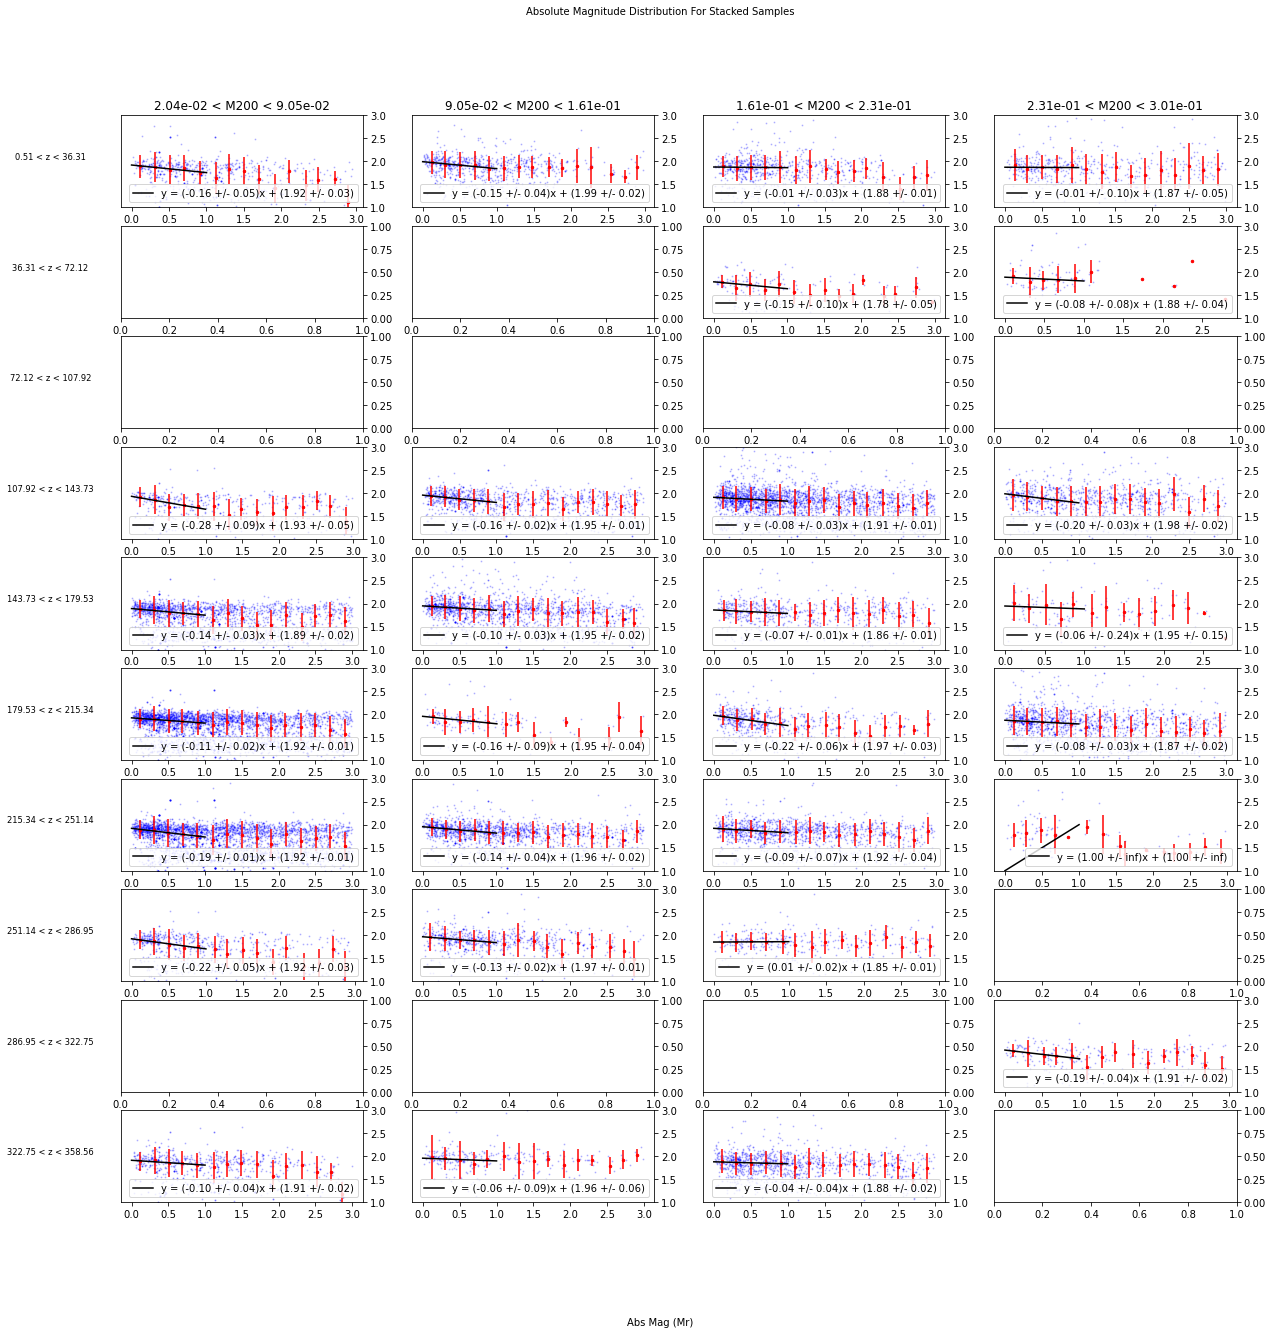

In [14]:
generateDn4000vsRnormPlots(plotDataDict, errorMethod = "std")

In [6]:
"""
*****************************************************************************
        Generates Member Dictionary And Calculates Completness Limits
*****************************************************************************
"""
lumDistDict = getLumDistDict()
memberClusterDict = genMemberDict(lumDistDict)
completnessDict, memberfractionDict = CalcCompletness() 
limit50 = getCompletenessLimit(completnessDict)

100%|█████████████████████████████████████████████|Generating Member Dictionary
100%|████████████|Calculating Completeness and Member Fraction for Each Cluster
100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


In [7]:
"""
*****************************************************************************
                              Applies The Corrrection
*****************************************************************************
"""
additionalMembersDict, additionalMembersLimitDict = getAdditionalMemberDict(memberClusterDict, lumDistDict, limit50)
sampledData = sampleAdditionalMembers(memberClusterDict, additionalMembersLimitDict) if(imposeLimitOnCorrection) else sampleAdditionalMembers(memberClusterDict, additionalMembersDict)
plotDataDict = assignAdditionalMembers(memberClusterDict, additionalMembersLimitDict, sampledData) if(imposeLimitOnCorrection) else assignAdditionalMembers(memberClusterDict, additionalMembersDict, sampledData)

100%|████████████|Calculating the Number of Additional Members for Each Cluster
100%|███████████████████████████████████████|Getting Stacked Sampled Parameters
100%|█████████████████████████|Assigning The Additional Members to Each Cluster


In [8]:
"""
*****************************************************************************
                              Finds Magnitude Limit
*****************************************************************************
"""
MrLimit = magnitudeLimit(plotDataDict)

100%|█████████████████████████████████████████████|Preparing The Stacked Sample
100%|██████████████████████████████████████████|Calculating The Magnitude Limit


100%|█████████████████████████████████████████████|Preparing The Stacked Sample
C:\Users\Colby\Anaconda3\envs\data_analytics\lib\site-packages\ipykernel_launcher.py:678: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
 60%|████████████████████████................|Generating Dn4000 vs. Rnorm PlotsC:\Users\Colby\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
C:\Users\Colby\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|████████████████████████████████████████|Generating Dn4000 vs. Rnorm Plots


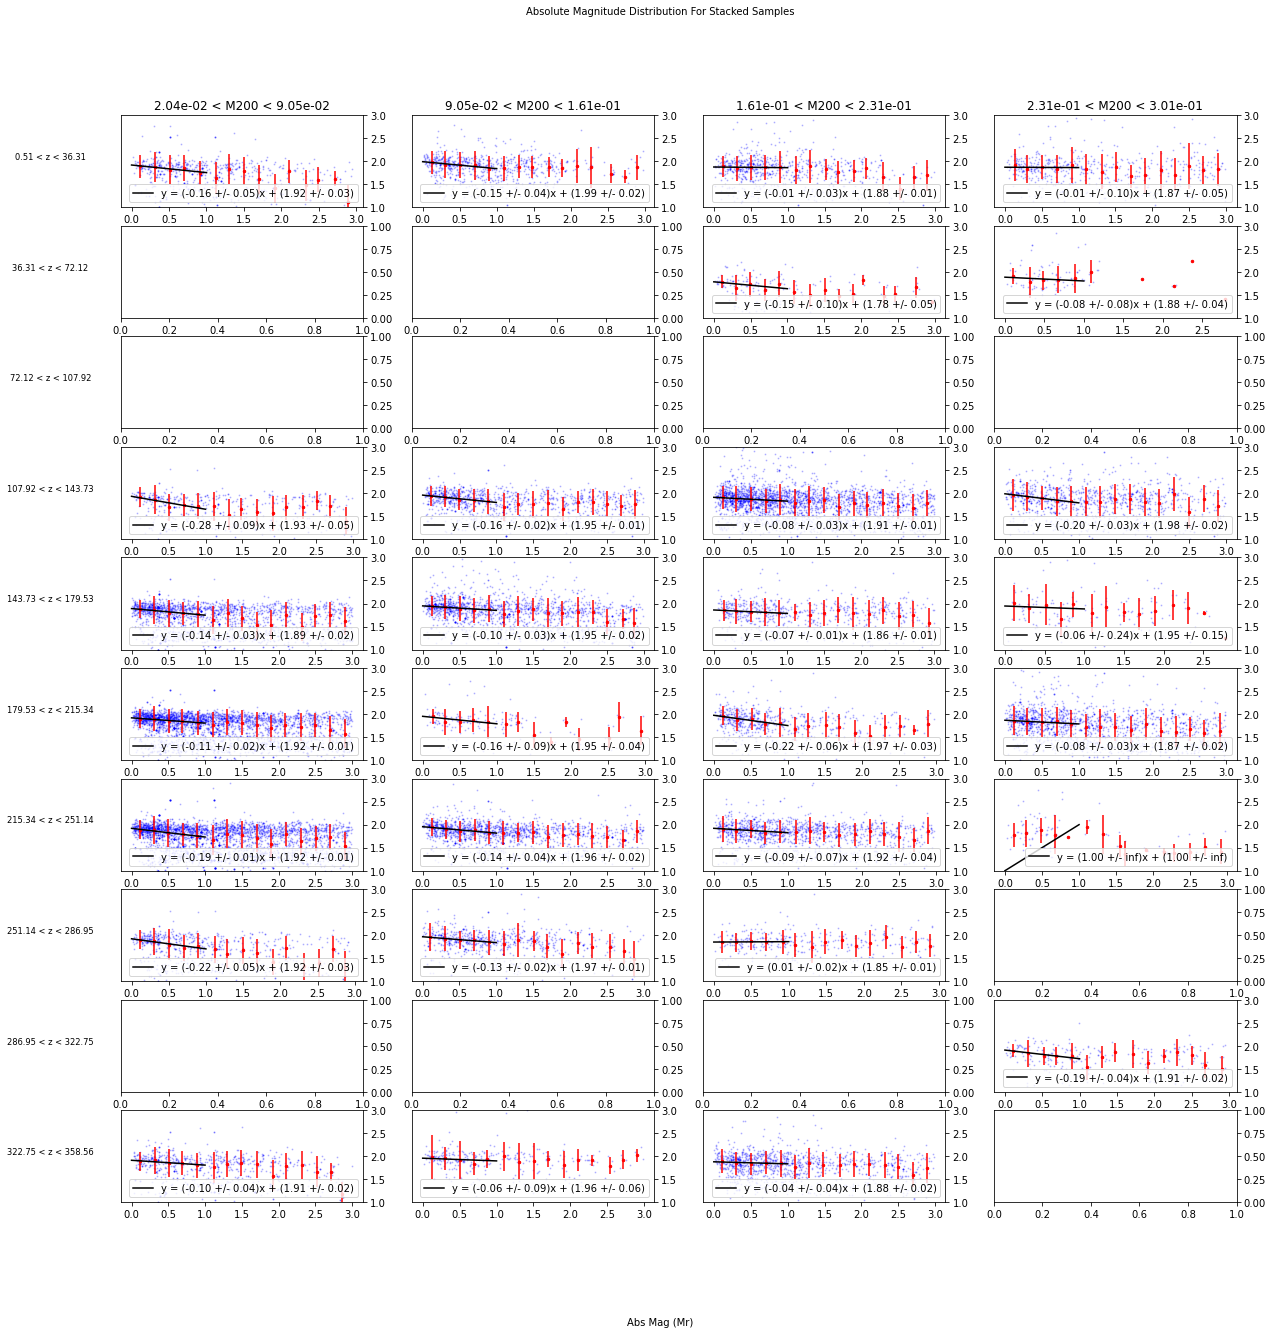

In [9]:
"""
*****************************************************************************
                              Dn4000 vs. Rnorm Plots/Fits
*****************************************************************************
"""
slopes, rowName, colName = generateDn4000vsRnormPlots(plotDataDict, errorMethod = "std")

plt.scatter(colName, slopes[:, 0])
plt.title(rowName[0])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeZ1.png")
plt.cla()

plt.scatter(colName, slopes[:, 1])
plt.title(rowName[1])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeZ2.png")
plt.cla()

plt.scatter(colName, slopes[:, 2])
plt.title(rowName[2])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeZ3.png")
plt.cla()

plt.scatter(colName, slopes[:, 3])
plt.title(rowName[3])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeZ4.png")
plt.cla()

plt.scatter(colName, slopes[:, 0], label=rowName[0])
plt.scatter(colName, slopes[:, 1], label=rowName[1])
plt.scatter(colName, slopes[:, 2], label=rowName[2])
plt.scatter(colName, slopes[:, 3], label=rowName[3])

plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.legend(loc='best')
plt.ylim(-0.6, 0)
plt.savefig("./slopeZS.png")
plt.cla()

plt.scatter(rowName, slopes[0, :])
plt.title(colName[0])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM1.png")
plt.cla()

plt.scatter(rowName, slopes[1, :])
plt.title(colName[1])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM2.png")
plt.cla()

plt.scatter(rowName, slopes[2, :])
plt.title(colName[2])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM3.png")
plt.cla()

plt.scatter(rowName, slopes[3, :])
plt.title(colName[3])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM4.png")
plt.cla()

plt.scatter(rowName, slopes[4, :])
plt.title(colName[4])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM5.png")
plt.cla()

plt.scatter(rowName, slopes[5, :])
plt.title(colName[5])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM6.png")
plt.cla()

plt.scatter(rowName, slopes[6, :])
plt.title(colName[6])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM7.png")
plt.cla()

plt.scatter(rowName, slopes[7, :])
plt.title(colName[7])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM8.png")
plt.cla()

plt.scatter(rowName, slopes[8, :])
plt.title(colName[8])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM9.png")
plt.cla()

plt.scatter(rowName, slopes[9, :])
plt.title(colName[9])
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
plt.savefig("./slopeM10.png")
plt.cla()

plt.scatter(rowName, slopes[0, :], label=colName[0])
plt.scatter(rowName, slopes[1, :], label=colName[1])
plt.scatter(rowName, slopes[2, :], label=colName[2])
plt.scatter(rowName, slopes[3, :], label=colName[3])
plt.scatter(rowName, slopes[4, :], label=colName[4])
plt.scatter(rowName, slopes[5, :], label=colName[5])
plt.scatter(rowName, slopes[6, :], label=colName[6])
plt.scatter(rowName, slopes[7, :], label=colName[7])
plt.scatter(rowName, slopes[8, :], label=colName[8])
plt.scatter(rowName, slopes[9, :], label=colName[9])

plt.title("Stacked")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Redshift Bin Number")
plt.ylabel("Slope")
#plt.legend(loc='best')
plt.ylim(-0.5,0.5)
#plt.show()
plt.savefig("./slopeMS.png")
plt.cla()


In [10]:
"""
*****************************************************************************
                           Relative Velocity Plots/Analysis 
*****************************************************************************
"""
#generateRelativeVelocityPlots(plotDataDict)

'\n*****************************************************************************\n                           Relative Velocity Plots/Analysis \n*****************************************************************************\n'